<a href="https://colab.research.google.com/github/nielsrolf/audio_playground/blob/master/SirenWavAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tf_siren

In [ ]:
!pip install youtube-dl

# Download soma audio data

In [ ]:
!youtube-dl https://soundcloud.com/thomash_voodoohop/thomash-all-my-pretty-horses
!ffmpeg -i 'Thomash - All My Pretty Monkeys-251418259.mp3' data.wav 
!youtube-dl https://soundcloud.com/lautundluise/christopher-schwarzwalder-das
!youtube-dl https://soundcloud.com/talderverwirrung/ninze-old-chap-billy-caso-remix
!ffmpeg -i 'Christopher Schwarzwalder - Das Ganze Boot Auf Acid-73632081.mp3' data2.wav 
!ffmpeg -i 'Ninze - Old Chap (Billy Caso'\''s Pineapple Remix)-268258980.mp3' data3.wav 

# Load the data

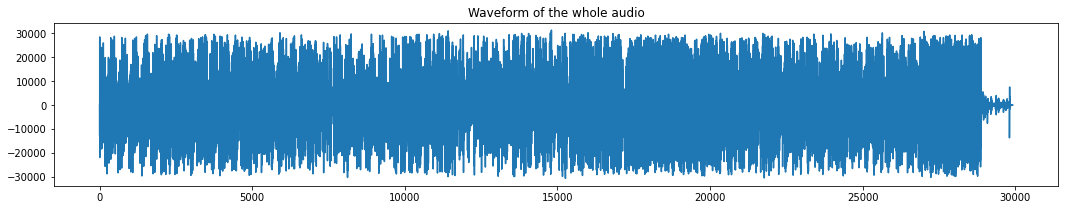

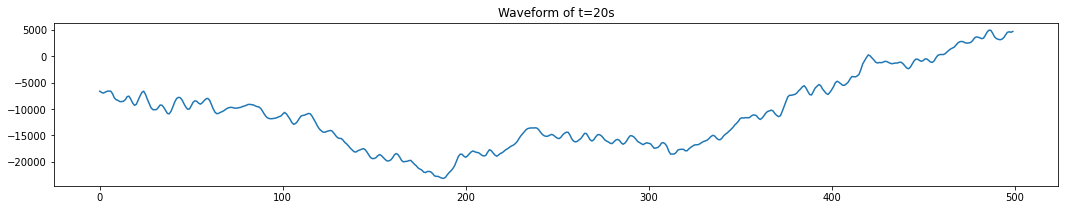

In [4]:
from scipy.io import wavfile
from matplotlib import pyplot as plt
from IPython.display import display, Audio

sr, wav = wavfile.read("data.wav")
wav = wav.mean(1) # stereo -> mono
wav.shape, sr

plt.figure(figsize=(18, 3))
plt.plot(wav[::sr//100])
plt.title("Waveform of the whole audio")
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(wav[sr*20:sr*20+500])
plt.title("Waveform of t=20s")
plt.show()

display(Audio(wav[sr*10:sr*20], rate=sr))

In [5]:
from glob import glob

wavs = []
for filename in glob("*.wav"):
    sr, wav = wavfile.read("data.wav")
    if wav.ndim == 2:
        wav = wav.mean(1)
    print(sr)
    wavs.append(wav)

44100
44100
44100


# Preprocessing

The idea is to train an autoencoder, where the decoder is a SIREN model and the encoder predicts its weights.

**What do we feed to the encoder?**
- fixed time audio snippets as waveform
- then preprocess with stft and keep it (almost) invertible: the only step in which we loose information is when we normalize the standard deviation per frequency


**What do we evaluate?** MSE on the waveform




In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D



inp = tf.keras.layers.Input(shape=[40*sr])
stft = tf.signal.stft(inp, sr//40, sr//80)
freq_scaler = tf.math.reduce_std(tf.math.real(stft), 1, keepdims=True) + 20
stft_real = tf.math.real(stft) / freq_scaler
stft_imag = tf.math.imag(stft) / freq_scaler

model = Model(inp, [stft_real, stft_imag, freq_scaler])

spec, phase, scaler = model.predict(wav[None,:40*sr])
spec, phase = spec[0], phase[0]


spec.shape, scaler.shape

((3200, 1025), (1, 1, 1025))

In [7]:
model.inputs, model.outputs, spec.std(0).shape

([<tf.Tensor 'input_1:0' shape=(None, 1764000) dtype=float32>],
 [<tf.Tensor 'RealDiv:0' shape=(None, 3200, 1025) dtype=float32>,
  <tf.Tensor 'RealDiv_1:0' shape=(None, 3200, 1025) dtype=float32>,
  <tf.Tensor 'AddV2_2:0' shape=(None, 1, 1025) dtype=float32>],
 (1025,))

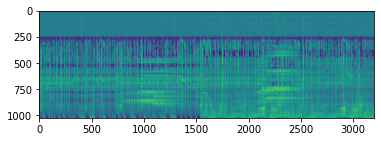

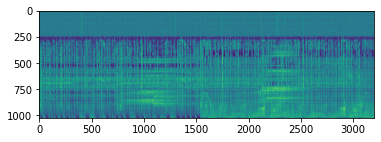

In [8]:
#spec = spec / (spec.std(-1, keepdims=True) + 1)
#plt.imshow(np.log(1+np.abs(spec[:,::-1].T)))

plt.imshow(np.log(0.001+np.abs(spec[:,::-1].T)))
plt.show()
plt.imshow(np.log(0.001+np.abs(phase[:,::-1].T)))
plt.show()

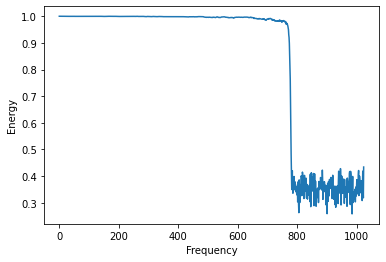

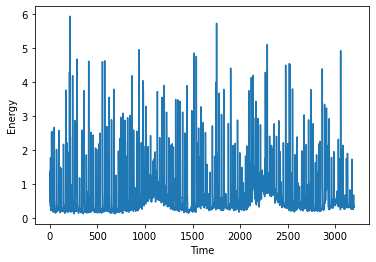

In [9]:
plt.plot(spec.std(0))
plt.xlabel("Frequency")
plt.ylabel("Energy")
plt.show()
plt.plot(spec.std(1))
plt.xlabel("Time")
plt.ylabel("Energy")
plt.show()

In [10]:
spec.min(), spec.max(), spec.mean(), spec.std()

(-28.185587, 29.15706, -6.7477326e-06, 0.8851596)

We can use these spectrograms as input for the decoder. However the values in the low frequencies have a super large scale

# Model

In [44]:
# The SinusodialRepresentation layer computes sin(Wx + b) where x=t in the first layer
# Here, we learn W through the meta network, i.e. W = W'e + b', where e is the encoded word


from tf_siren import Sine, SIRENInitializer, SinusodialRepresentationDense
from tensorflow.keras.layers import Conv2D, Flatten, Dense





# X: (None, T, d_in)
# E: (None, d_e)
# W0: (d_e, d_in, d_out)
# B0: (d_in, d_out)
# W: (None, d_in, d_out) = E W0 + B0
# b: (d_out)
# Wx + b => (None, T, d_out)
class SIRENDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, w0=1, c=6):
        super().__init__()
        self.units = units
        self.w0 = w0
        self.c = c
        self.activation = Sine(w0=w0)

    def build(self, inputs_shape):
        d_in = inputs_shape[0][-1]
        d_e = inputs_shape[1][1]
        kernel_initializer = SIRENInitializer(w0=self.w0, c=self.c)
        bias_initializer = SIRENInitializer(w0=self.w0, c=self.c)
        self.w = self.add_weight(
            shape=(d_e, d_in, self.units),
            initializer=kernel_initializer,
            trainable=True,
        )
        self.b0 = self.add_weight(
            shape=(d_in, self.units,), initializer=bias_initializer, trainable=True
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer=bias_initializer, trainable=True
        )

    def call(self, inputs):
        x, code = inputs[0], inputs[1]
        # x: (B, T, C_in)
        # code: (B, 512)
        w = tf.tensordot(code, self.w, [-1, 0]) + self.b0
        # w: (B, C_in, C_out)
        outputs = tf.reduce_sum(tf.expand_dims(w, 1)*tf.expand_dims(x, 3), axis=2) + self.b
        # outputs: (B, T, C_out)
        print(inputs[0].shape, "=>", outputs.shape)
        return self.activation(outputs)


tf.keras.utils.get_custom_objects().update({
    'SIRENDecoderLayer': SIRENDecoderLayer
})



# encoder
LEN = 5*sr
inp = tf.keras.layers.Input(shape=[LEN])

# encoder preprocessing
stft = tf.signal.stft(inp, sr//40, sr//80)
freq_scaler = tf.math.reduce_std(tf.math.real(stft), 1, keepdims=True) + 20
stft_real = tf.math.real(stft) / freq_scaler
stft_imag = tf.math.imag(stft) / freq_scaler
stft_2c = tf.stack([stft_real, stft_imag], axis=-1)
# shape: (time, freq:1025, channel:2)
x = Conv2D(512, kernel_size=(10, 1025), strides=(5, 1), padding='valid', activation='relu')(stft_2c)
x = Conv2D(512, kernel_size=(10, 1), strides=(5, 1), padding='same', activation='relu')(x)
x = Conv2D(512, kernel_size=(10, 1), strides=(2, 1), padding='same', activation='relu')(x)
x = Conv2D(512, kernel_size=(10, 1), strides=(2, 1), padding='same', activation='tanh')(x)
x = Flatten()(x)
freq_scaler = Flatten()(freq_scaler)
x = tf.concat([x, freq_scaler], -1)
code = Dense(512, activation='tanh')(x)
# encoder 1d convolutions
encoder = Model(inp, code)


code = tf.keras.layers.Input(shape=[512])
time = tf.reshape(tf.range(0, LEN, dtype=tf.float32), [1, LEN, 1])

x = SIRENDecoderLayer(32)([time, code])
x = SIRENDecoderLayer(32)([x, code])
x = SinusodialRepresentationDense(1, activation=None)(x)
x = tf.squeeze(x)
                                  
decoder = tf.keras.Model(inputs=code, outputs=x)

inp = tf.keras.layers.Input(shape=[LEN])
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)

autoencoder.compile(optimizer='rmsprop', loss=tf.keras.losses.MeanAbsoluteError())
autoencoder.summary()

(1, 220500, 1) => (None, 220500, 32)
(None, 220500, 32) => (None, 220500, 32)
(None, 220500, 32) => (None, 220500, 32)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 220500)]          0         
_________________________________________________________________
model_7 (Model)              (None, 512)               19936256  
_________________________________________________________________
model_8 (Model)              None                      525377    
Total params: 20,461,633
Trainable params: 20,461,633
Non-trainable params: 0
_________________________________________________________________


In [23]:
import random

wav_scaling = np.std(wavs[0])
def data_generator(batch_size):
    while True:
        batch = []
        for _ in range(batch_size):
            wav = random.choice(wavs)
            start = random.randint(0, len(wav)-LEN)
            batch.append(
                wav[start:start+LEN]
            )
        batch = np.array(batch)/wav_scaling
        yield batch, batch

In [45]:
autoencoder.fit(data_generator(4), epochs=1, steps_per_epoch=1000)

(None, 220500, 32) => (None, 220500, 32)
(None, 220500, 32) => (None, 220500, 32)
1000/1000 [==============================] - 378s 378ms/step - loss: 1.4373


In [46]:
gen = decoder.predict(np.zeros([1, 512]))*wav_scaling
display(Audio(gen, rate=44100))

(None, 220500, 32) => (None, 220500, 32)


In [47]:

gen = autoencoder.predict(batch)*wav_scaling
display(Audio(gen[0], rate=44100))

(None, 220500, 32) => (None, 220500, 32)


In [49]:
encoder.predict(batch)

array([[-1.,  1., -1., ...,  1., -1., -1.],
       [-1.,  1., -1., ...,  1., -1., -1.],
       [-1.,  1., -1., ...,  1., -1., -1.],
       [-1.,  1., -1., ...,  1., -1., -1.]], dtype=float32)

In [38]:
batch = []
for _ in range(4):
    wav = random.choice(wavs)
    start = random.randint(0, len(wav)-LEN)
    batch.append(
        wav[start:start+LEN]
    )
batch = np.array(batch)/wav_scaling

In [50]:
gen[0] == gen[1]

array([ True,  True,  True, ...,  True,  True,  True])